
--- Accuracy ---
Logistic Regression: 0.6667
Random Forest      : 1.0


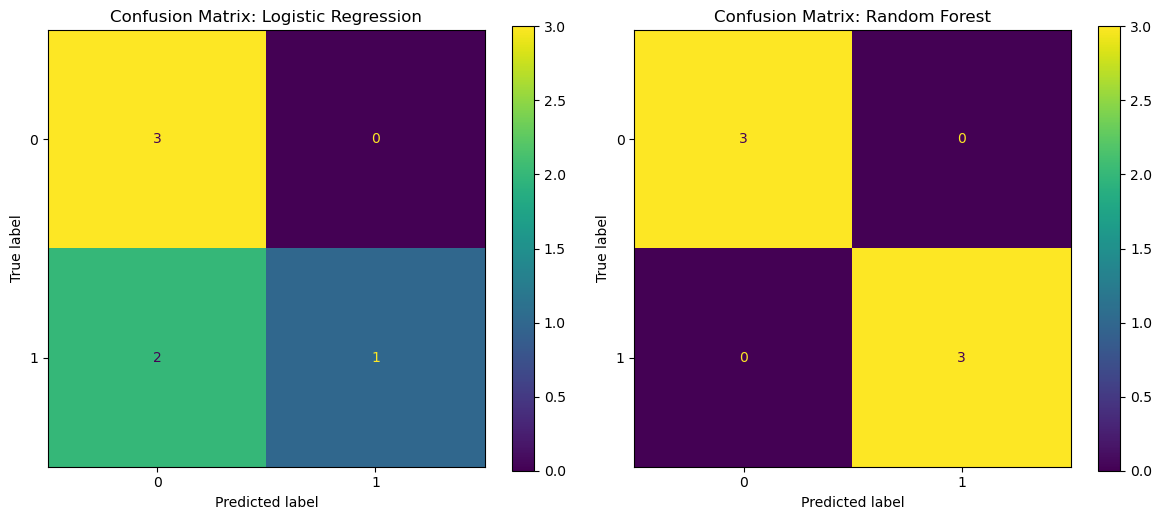

<Figure size 800x600 with 0 Axes>

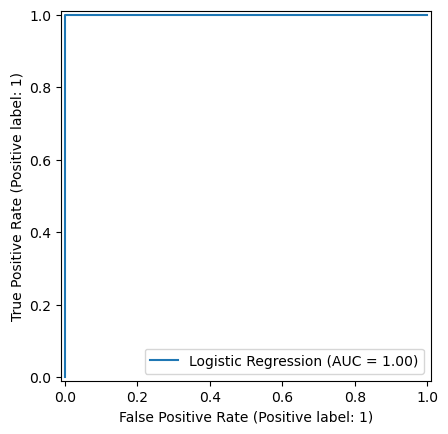

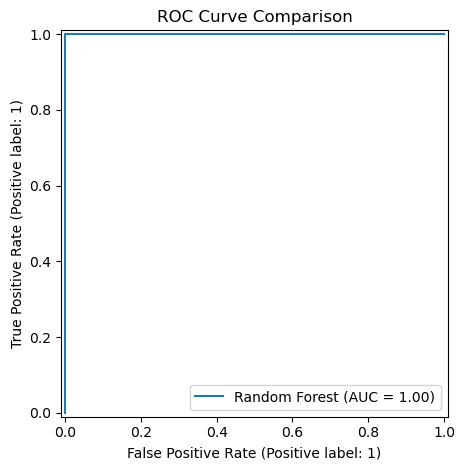

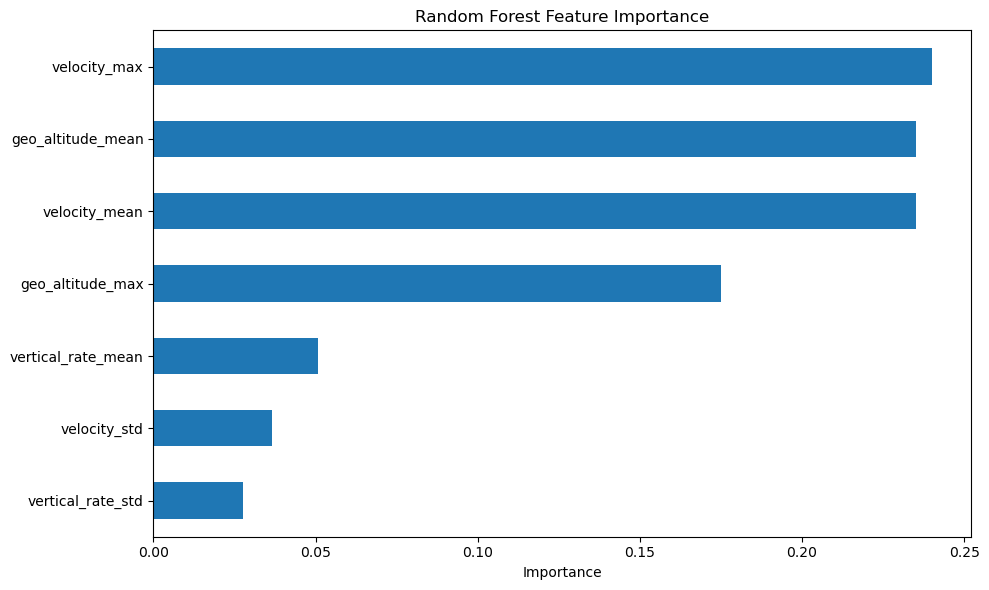

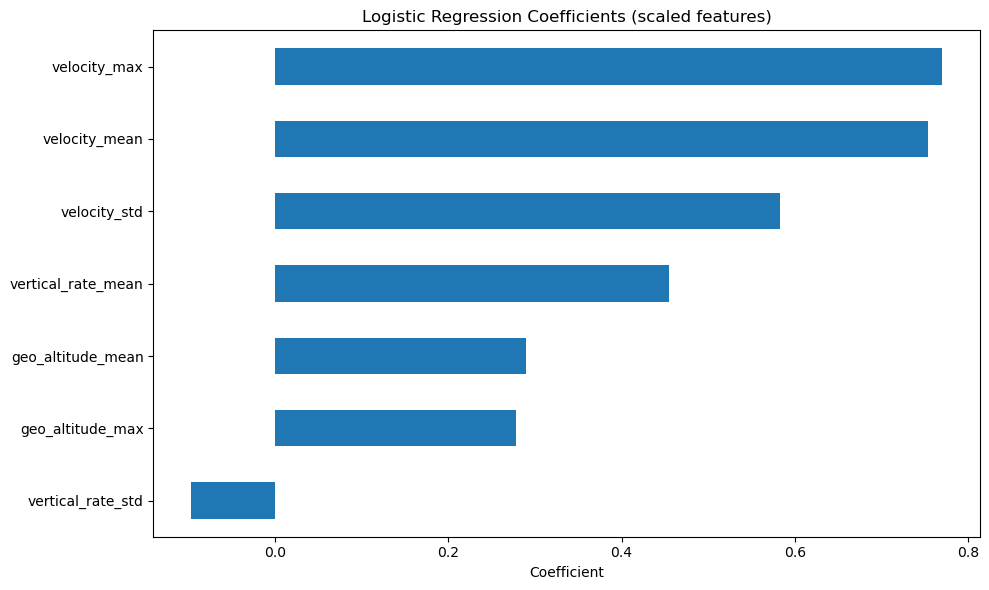


Target definition used for demo:
high_altitude = 1 if geo_altitude_mean > median (508.63), else 0


In [1]:
# --- Drop-in demo: flight-level features -> Logistic Regression + Random Forest + plots ---

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

# ----------------------------
# 1) Load data
# ----------------------------
BASE_DIR = Path.cwd()
file_path = BASE_DIR / ".." / ".." / "data" / "iad_dca_states_smoketest.parquet"

df = pd.read_parquet(file_path)

# Ensure timestamp is datetime (UTC)
if "snapshot_time" not in df.columns:
    raise ValueError(f"'snapshot_time' not found in columns: {list(df.columns)}")

df["snapshot_time"] = pd.to_datetime(df["snapshot_time"], utc=True)

# Basic cleaning (dedupe by aircraft+time, sort)
df = (
    df.sort_values(["icao24", "snapshot_time"])
      .drop_duplicates(subset=["icao24", "snapshot_time"])
)

# Optional: filter out invalid values if columns exist
for col in ["velocity", "geo_altitude"]:
    if col in df.columns:
        df = df[df[col].notna()]

if "velocity" in df.columns:
    df = df[df["velocity"] >= 0]
if "geo_altitude" in df.columns:
    df = df[df["geo_altitude"] >= 0]

# ----------------------------
# 2) Build flight-level features (your requested approach)
# ----------------------------
required_cols = {"icao24", "velocity", "geo_altitude", "vertical_rate"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns for feature build: {missing}")

flight_features = df.groupby("icao24").agg({
    "velocity": ["mean", "max", "std"],
    "geo_altitude": ["mean", "max"],
    "vertical_rate": ["mean", "std"],
})

# Flatten columns: ("velocity","mean") -> "velocity_mean"
flight_features.columns = ["_".join(col) for col in flight_features.columns]

# Drop aircraft with insufficient samples (std becomes NaN if only 1 point)
flight_features = flight_features.dropna().copy()

# ----------------------------
# 3) Create a demo target label (replace with your real label later)
#    Example: "high_altitude" if mean geo_altitude > median
# ----------------------------
threshold = flight_features["geo_altitude_mean"].median()
flight_features["high_altitude"] = (flight_features["geo_altitude_mean"] > threshold).astype(int)

X = flight_features.drop(columns=["high_altitude"])
y = flight_features["high_altitude"]

# ----------------------------
# 4) Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# ----------------------------
# 5) Models
# ----------------------------
# Logistic Regression (scaled)
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

# Random Forest (no scaling needed)
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# ----------------------------
# 6) Quick metrics
# ----------------------------
log_pred = log_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

print("\n--- Accuracy ---")
print("Logistic Regression:", round(accuracy_score(y_test, log_pred), 4))
print("Random Forest      :", round(accuracy_score(y_test, rf_pred), 4))

# ----------------------------
# 7) Plots: Confusion Matrices
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, ax=ax[0])
ax[0].set_title("Confusion Matrix: Logistic Regression")

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=ax[1])
ax[1].set_title("Confusion Matrix: Random Forest")

plt.tight_layout()
plt.show()

# ----------------------------
# 8) Plots: ROC Curves
# ----------------------------
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_model, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest")
plt.title("ROC Curve Comparison")
plt.tight_layout()
plt.show()

# ----------------------------
# 9) Plot: Random Forest Feature Importance
# ----------------------------
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
importances.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ----------------------------
# 10) Optional: Logistic Regression coefficients (interpretability)
# ----------------------------
coef = pd.Series(log_model.named_steps["model"].coef_[0], index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
coef.plot(kind="barh")
plt.title("Logistic Regression Coefficients (scaled features)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

print("\nTarget definition used for demo:")
print(f"high_altitude = 1 if geo_altitude_mean > median ({threshold:.2f}), else 0")
